# Node Position Generator and Simulation Configurator

This notebook provides tools to generate and visualize node positions for simulations and to create files for configuring simulation environments. 

## Features:
### Position File Generation
- **Fixed Nodes:** Nodes that remain static at specified positions.
- **Mobile Nodes:** Nodes that move back and forth along predefined straight-line segments between start and end positions.
- **Parallel Motion:** All mobile nodes move simultaneously instead of sequentially.
- **Continuous Bidirectional Movement:** Ensures smooth motion without sudden position resets.
- **Coverage Circles:** Each node is surrounded by a dashed circle representing a configurable coverage radius.

### Simulation Configuration (XML)
- **Automatic `simulation.xml` Generation:** Updates an existing XML file with new simulation parameters.
- **Configurable Transmission and Interference Ranges:** Adjusts radio communication settings dynamically.
- **Root and Client Nodes Differentiation:** Organizes nodes into root (server) and client (non-root) categories.
- **Maintains Script Integrity:** Ensures the embedded `<![CDATA[ ... ]]>` script section remains unmodified except for simulation timeout updates.

## Usage:
1. Define the fixed and mobile nodes, along with their movement parameters.
2. Run the position file generator to create `positions.dat`.
3. Use the plot function to visualize node distributions and movement trajectories.
4. Use the XML generator to update `simulation.xml` with the correct node configuration, preserving structure and logic.

This tool is useful for wireless sensor networks (WSN), mobile ad-hoc networks (MANETs), and other simulations involving node mobility.

## Position method generator

In [80]:
import numpy as np

def generate_positions_file(fixed_positions, mobile_start, mobile_end, mobile_speeds, mobile_time_steps, filename="positions.dat"):
    with open(filename, "w") as file:
        # Escreve os motes fixos
        file.write("# Fixed positions\n")
        for i, (x, y) in enumerate(fixed_positions):
            file.write(f"{i} 0.00000000 {x:.2f} {y:.2f}\n")
        file.write("\n")
        
        # Escreve os motes móveis
        file.write("# Mobile nodes\n")
        mote_index = len(fixed_positions)
        
        max_steps = 0
        
        mobile_trajectories = []
        for start, end, speed, time_step in zip(mobile_start, mobile_end, mobile_speeds, mobile_time_steps):
            x_start, y_start = start
            x_end, y_end = end
            
            distance = np.sqrt((x_end - x_start) ** 2 + (y_end - y_start) ** 2)
            duration = distance / speed  # Tempo total de ida
            steps = int(duration / time_step)  # Número de passos
            
            max_steps = max(max_steps, steps)
            
            x_values = np.linspace(x_start, x_end, steps)
            y_values = np.linspace(y_start, y_end, steps)
            
            x_full = np.concatenate((x_values, x_values[::-1]))
            y_full = np.concatenate((y_values, y_values[::-1]))
                        
            mobile_trajectories.append((mote_index, x_full, y_full))
            mote_index += 1
        
        for step in range(2 * max_steps):  # Iteração sobre todos os passos no tempo
            for mote_id, x_full, y_full in mobile_trajectories:
                if step < len(x_full):
                    file.write(f"{mote_id} {step * time_step:.8f} {x_full[step]:.2f} {y_full[step]:.2f}\n")
            file.write("\n")
    
    print(f"File {filename} generated successfully!")


## Simulation XML generator

In [ ]:
import xml.etree.ElementTree as ET
import xml.dom.minidom as minidom

def update_simulation_xml(fixed_positions, mobile_positions, root_motes, simulation_time, tx_range, interference_range, inputFile, outputFile):
    tree = ET.parse(inputFile)
    root = tree.getroot()
    
    # Updates radio parameters
    radiomedium = root.find(".//radiomedium")
    radiomedium.find("transmitting_range").text = str(tx_range)
    radiomedium.find("interference_range").text = str(interference_range)
    
    # Update simulation time in JS script keeping CDATA
    script_element = root.find(".//script")
    script_text = script_element.text
    new_timeout = simulation_time * 60000  # Convertendo minutos para milissegundos
    script_text = script_text.replace("const timeOut = 9000000 * 1000;", f"const timeOut = {new_timeout} * 1000;")
    script_text = script_text.replace("TIMEOUT(9001000);", f"TIMEOUT({new_timeout + 1000});")
    script_element.text = f"<![CDATA[\n{script_text}\n]]>"
    
    # update motes
    motetype_root = root.find(".//motetype[description='server']")
    motetype_client = root.find(".//motetype[description='client']")
    
    for mote in motetype_root.findall("mote"):
        motetype_root.remove(mote)
    for mote in motetype_client.findall("mote"):
        motetype_client.remove(mote)
    
    for i, (x, y) in enumerate(fixed_positions + mobile_positions):
        mote_type = motetype_root if i + 1 in root_motes else motetype_client
        mote = ET.SubElement(mote_type, "mote")
        
        interface_config = ET.SubElement(mote, "interface_config")
        interface_config.text = "org.contikios.cooja.interfaces.Position"
        ET.SubElement(interface_config, "pos", x=str(x), y=str(y))
        
        id_config = ET.SubElement(mote, "interface_config")
        id_config.text = "org.contikios.cooja.contikimote.interfaces.ContikiMoteID"
        ET.SubElement(id_config, "id").text = str(i + 1)
    
    xml_str = ET.tostring(root, encoding='utf-8')
    parsed_xml = minidom.parseString(xml_str)
    with open(outputFile, "w", encoding="utf-8") as f:
        output = parsed_xml.toprettyxml(indent="  ")
        output = output.replace("?>", "encoding=\"UTF-8\"?>")
        output = output.replace("&gt;", ">")
        output = output.replace("&lt;", "<")
        output = output.replace("&quot;", "\"")
        output = output.replace("<![CDATA[\n", "<![CDATA[")
        output = output.replace("\n]]>", "]]>")
        
        # Remove blank lines, exceto dentro de CDATA
        inside_cdata = False
        lines_without_blanks = []
        for line in output.splitlines():
            if "<![CDATA[" in line:
                inside_cdata = True
            if inside_cdata or line.strip():
                lines_without_blanks.append(line)
            if "]]>" in line:
                inside_cdata = False
                
        final_content = "\n".join(lines_without_blanks)
        f.write(final_content)
    
    print(f"File {outputFile} generated successfully!")

## Parameterize and generate files

In [ ]:
FIXED_POSITIONS=[
    (10, 10), # Mote 1
    (50, 10), # Mote 2
    (90, 10), # Mote 3
    (10, 50), # Mote 4
    (90, 50), # Mote 5
    (10, 90), # Mote 6
    (90, 90)] # Mote 7

MOBILE_START=[
    (20, 70), # Mote 8
    (30, 80)] # Mote 9

generate_positions_file(
    fixed_positions=FIXED_POSITIONS,
    mobile_start=MOBILE_START,
    mobile_end=[
        (70, 20),  # Mote 8
        (80, 30)], # Mote 9
    mobile_speeds=[2.0, 1.5],
    mobile_time_steps=[3, 3],
    filename="positions.dat"
)

update_simulation_xml(
    fixed_positions=FIXED_POSITIONS,
    mobile_positions=MOBILE_START,
    root_motes=[1], # Server motes, the others will be clients
    simulation_time=150, # in minutes
    tx_range=50.0, 
    interference_range=100.0,
    inputFile="simulation_template.xml", # Template file for building the simulation xml
    outputFile="simulation.xml"
)

File positions.dat generated successfully!
File simulation.xml generated successfully!


## Plots

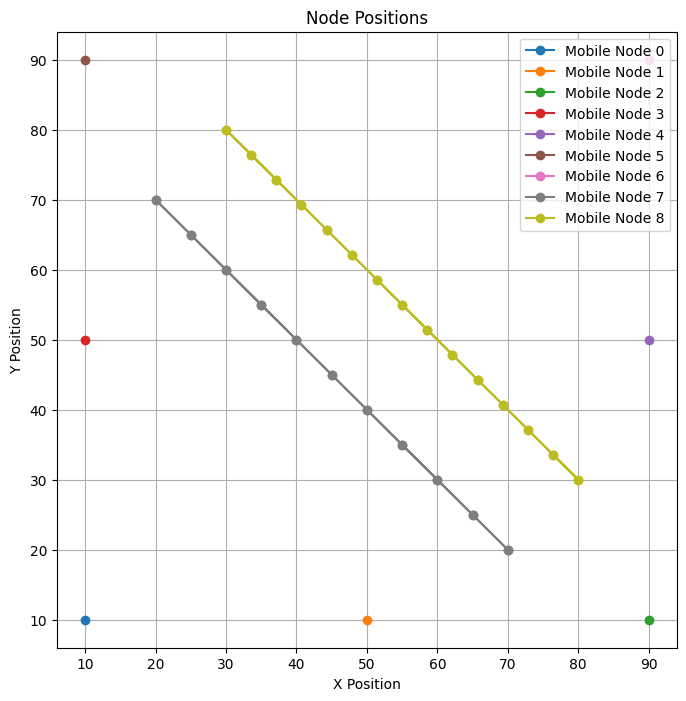

In [ ]:
import matplotlib.pyplot as plt

def plot_positions(filename="positions.dat"):
    fixed_positions = []
    mobile_positions = {}
    
    with open(filename, "r") as file:
        for line in file:
            if line.startswith("#") or line.strip() == "":
                continue
            parts = line.split()
            mote_id, _, x, y = int(parts[0]), float(parts[1]), float(parts[2]), float(parts[3])
            
            if mote_id not in mobile_positions and len(fixed_positions) > mote_id:
                fixed_positions.append((x, y))
            else:
                if mote_id not in mobile_positions:
                    mobile_positions[mote_id] = []
                mobile_positions[mote_id].append((x, y))
    
    plt.figure(figsize=(8, 8))
    
    # Plot fixed motes
    if fixed_positions:
        x_fixed, y_fixed = zip(*fixed_positions)
        plt.scatter(x_fixed, y_fixed, color='red', marker='o', label='Fixed Nodes')
    
    # Plot mobile motes
    for mote_id, positions in mobile_positions.items():
        x_mobile, y_mobile = zip(*positions)
        plt.plot(x_mobile, y_mobile, marker='o', linestyle='-', label=f'Mobile Node {mote_id}')
    
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.title("Node Positions")
    plt.legend()
    plt.grid()
    plt.show()

plot_positions("positions.dat")

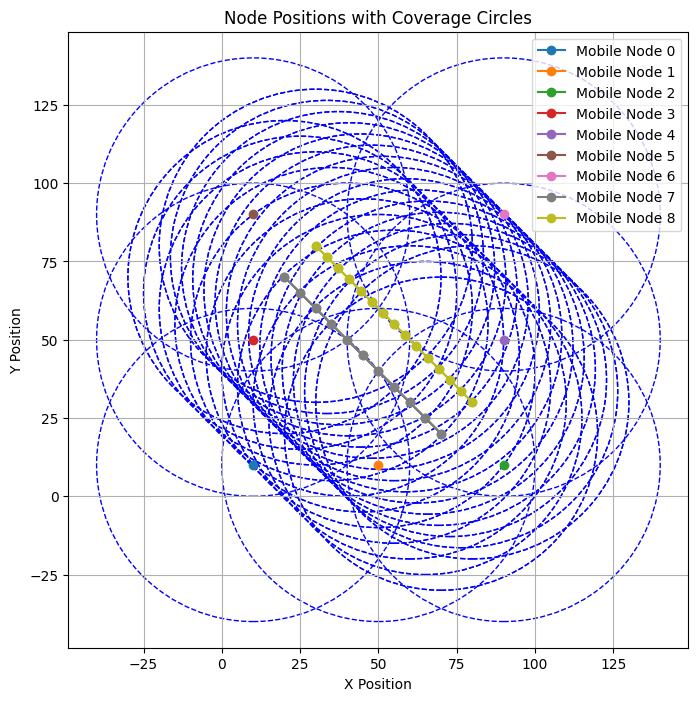

In [ ]:
import matplotlib.pyplot as plt

def plot_positions_with_radius(filename="positions.dat", radius=10):
    fixed_positions = []
    mobile_positions = {}
    
    with open(filename, "r") as file:
        for line in file:
            if line.startswith("#") or line.strip() == "":
                continue
            parts = line.split()
            mote_id, _, x, y = int(parts[0]), float(parts[1]), float(parts[2]), float(parts[3])
            
            if mote_id not in mobile_positions and len(fixed_positions) > mote_id:
                fixed_positions.append((x, y))
            else:
                if mote_id not in mobile_positions:
                    mobile_positions[mote_id] = []
                mobile_positions[mote_id].append((x, y))
    
    plt.figure(figsize=(8, 8))
    
    # Plot fixed motes
    if fixed_positions:
        x_fixed, y_fixed = zip(*fixed_positions)
        plt.scatter(x_fixed, y_fixed, color='red', marker='o', label='Fixed Nodes')
        for x, y in fixed_positions:
            circle = plt.Circle((x, y), radius, color='red', linestyle='dashed', fill=False)
            plt.gca().add_patch(circle)
    
    # Plot mobile motes
    for mote_id, positions in mobile_positions.items():
        x_mobile, y_mobile = zip(*positions)
        plt.plot(x_mobile, y_mobile, marker='o', linestyle='-', label=f'Mobile Node {mote_id}')
        for x, y in positions:
            circle = plt.Circle((x, y), radius, color='blue', linestyle='dashed', fill=False)
            plt.gca().add_patch(circle)
    
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.title("Node Positions with Coverage Circles")
    plt.legend()
    plt.grid()
    plt.axis("equal")
    plt.show()

plot_positions_with_radius("positions.dat", radius=50)
